In [ ]:
#Librerías usadas
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [ ]:
#Cargar el dataset
artists_billboard = pd.read_csv('artists_billboard_fix3.csv')

Preprocesado

Edad del artista al llegar al billboard

In [ ]:
#convertir valores 0 a None
def edad_fix(row):
  if row['anioNacimiento']==0:
      return None
  return row['anioNacimiento']

artists_billboard['anioNacimiento']=artists_billboard.apply(edad_fix, axis=1)

In [ ]:
#Nueva columna con edad del artista al llegar al billboard
def calcula_edad(row):
    cad = str(row['chart_date'])
    year = row['anioNacimiento']
    momento = cad[:4]
    if year==0.0:
        return None
    return int(momento) - year

artists_billboard['edad_en_billboard']=artists_billboard.apply(calcula_edad, axis=1)

In [ ]:
#Agregar valores aleatorios a los valores None de
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)

Mapear los valores de todas las categorías a números. Y convertir a categorías la edad al llegar al billboard

In [ ]:
# Mood Mapping
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6,
                                        'Empowering': 6,
                                        'Cool': 5,
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3,
                                        'Sensual': 2,
                                        'Gritty': 3, #coraje
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3,
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4,
                                        'Romantic': 2,
                                        'Peaceful': 1,
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4,
                                          'Pop': 3,
                                          'Traditional': 2,
                                          'Alternative & Punk': 1,
                                         'Electronica': 1,
                                          'Rock': 1,
                                          'Soundtrack': 0,
                                          'Jazz': 0,
                                          'Other':0,'':0}
                                       ).astype(int)
# artist_type Mapping
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)


# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

In [ ]:
#Quitar las columnas no categorizadas o innecesarias
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

Diseño de experimento para la busqueda del árbol de decisión

In [ ]:
cv = KFold(n_splits=10) #9 folds para entrenar y 1 para validar
accuracies = list() #Almacena la precisión de cada árbol creado
max_attributes = len(list(artists_encoded)) #Número máximo de columnas en el dataset usado
depth_range = range(1, max_attributes + 1) #Diferentes niveles de profundidad de los árboles

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = [] #Precisión de cada fold
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold]
        f_valid = artists_encoded.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['top'], axis=1),
                               y = f_train["top"])
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1),
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556126
         3          0.564038
         4          0.650446
         5          0.603199
         6          0.620511
         7          0.636210


Se observa que el mejor resultado es el árbol número 4, con una puntación un poco mejor a la del tutorial

Crear la imagen del árbol de decisión con profundidad máxima de 7

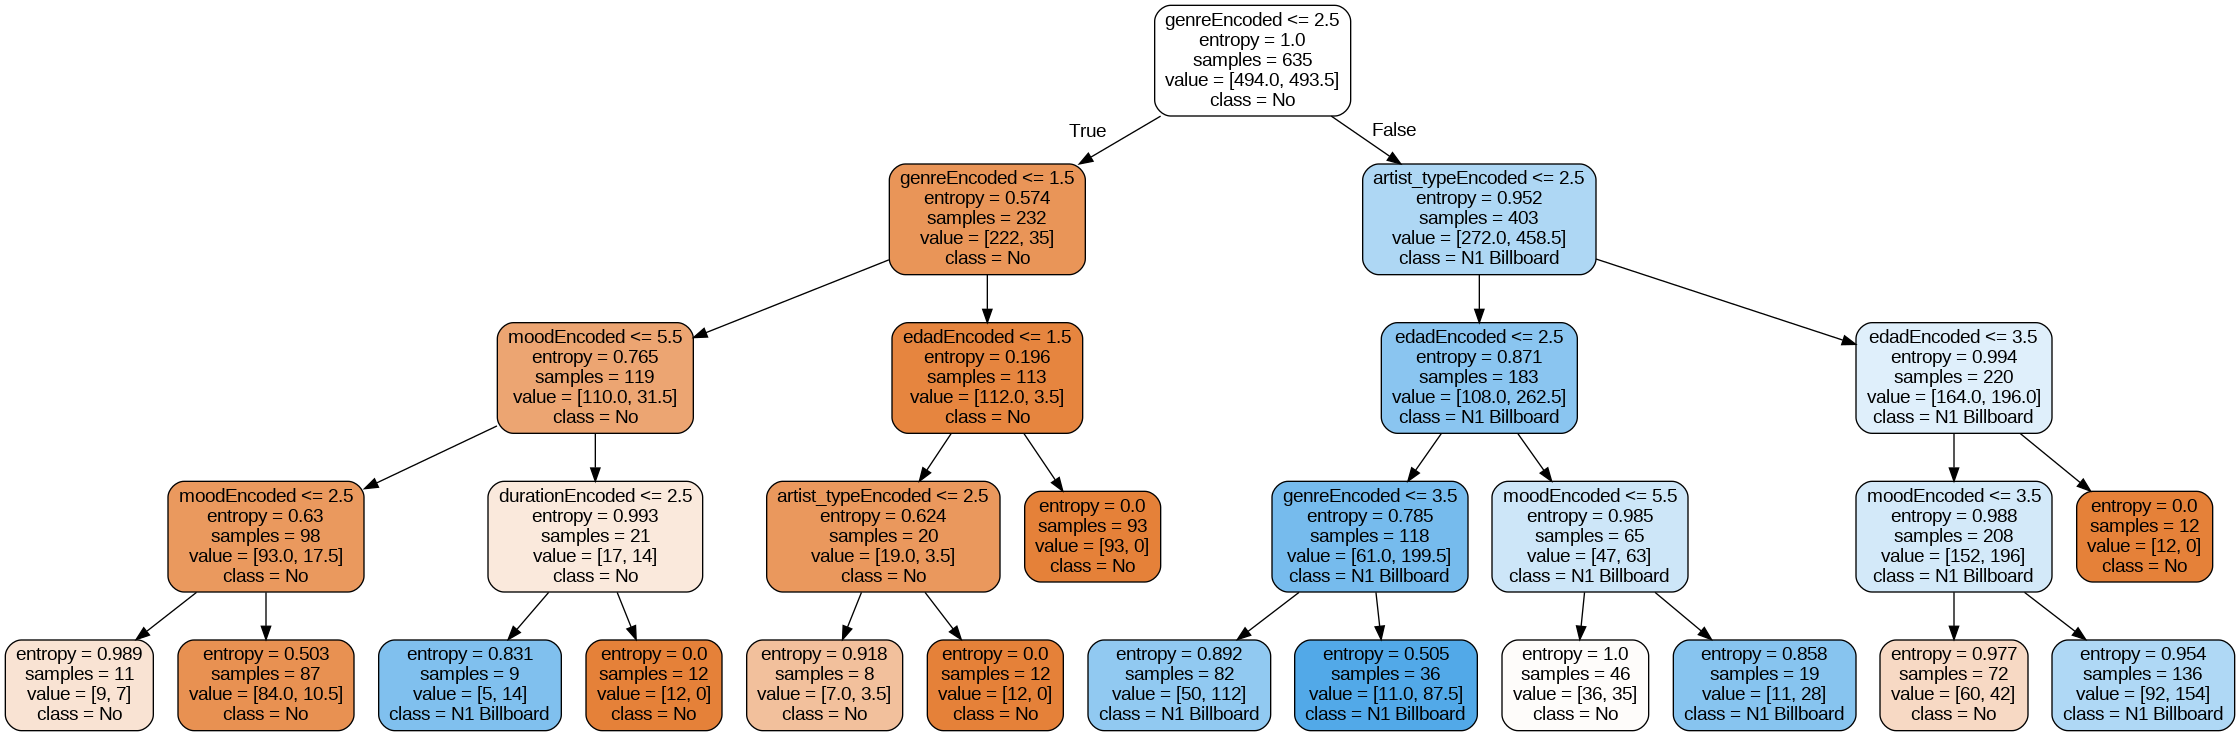

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")